# ⚽ Clustering Moroccan Football Players with Similar Skillset using K-Means 🇲🇦

### 🎯 About the Project

In this project, the primary objective is to address the challenge of categorizing Moroccan football players based on their skillsets. The project begins by defining the problem statement, which involves clustering players into five distinct categories: goalkeepers, defenders, offensive midfielders, defensive midfielders, and strikers. To accomplish this task, the K-Means clustering algorithm is employed, and the report elaborates on the inner workings of this algorithm. It also provides insights into the FIFA 22 dataset, emphasizing data exploration, analysis, and visualization to gain a comprehensive understanding of the player attributes. The subsequent sections of the project encompass the development of the K-Means clustering algorithm through pseudocode and code implementation, followed by visual representation of the clusters generated. Additionally, the project assesses the performance of the developed algorithm by comparing it to the scikit-learn implementation, thereby offering a comprehensive approach to player clustering based on skillsets.

### I. Importing libraries 🔌

In [892]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import json

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Pre processing
from sklearn import preprocessing

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

### II. Importing the dataset 💿

In [893]:
df = pd.read_csv("../data/players_22.csv", low_memory=False)
df.head(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [894]:
df.shape

(19239, 110)

### III. Data Cleaning 🧹

Deleting columns with more than 50% of missing values

In [895]:
cols_to_drop = []
for i in df.columns:
    missing = np.abs((df[i].count() - df[i].shape[0])/df[i].shape[0] * 100)
    if missing > 50:
        print('{} - {}%'.format(i, round(missing)))
        cols_to_drop.append(i)

club_loaned_from - 94%
nation_team_id - 96%
nation_position - 96%
nation_jersey_number - 96%
player_tags - 93%
player_traits - 51%
goalkeeping_speed - 89%
nation_logo_url - 96%


Let's delete the columns **club_loaned_from, nation_team_id, nation_position, nation_jersey_number, player_tags, player_traits, goalkeeping_speed** who have more than 50% of missing values.

In [896]:
df.drop(columns=cols_to_drop, inplace=True)
print(df.shape)

(19239, 102)


In [897]:
df.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url',
       'club_logo_url', 'club_flag_url', 'nation_flag_url'],
      dtype='object', length=102)

Now let's keep only players with the Moroccan 🇲🇦 Nationality

In [898]:
df = df[df.nationality_name == 'Morocco']

In [899]:
df.shape

(101, 102)

To have a nicer visualization of the clusters afterwards, we'll be keeping only the top players (rating over 70).

In [900]:
df = df[df.overall > 70]
print(df.shape)

(43, 102)


Dropping columns with urls in them.

In [901]:
df = df[df.columns.drop(list(df.filter(regex='url')))]
        
df.shape

(43, 97)

Replacing null values with the mean

In [902]:
df.isnull().sum()

sofifa_id           0
short_name          0
long_name           0
player_positions    0
overall             0
                   ..
lcb                 0
cb                  0
rcb                 0
rb                  0
gk                  0
Length: 97, dtype: int64

In [903]:
df = df.fillna(df.mean())

C:\Users\hamza\AppData\Local\Temp\ipykernel_7232\114435927.py:1: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [904]:
df.columns

Index(['sofifa_id', 'short_name', 'long_name', 'player_positions', 'overall',
       'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm',
       'weight_kg', 'club_team_id', 'club_name', 'league_name', 'league_level',
       'club_position', 'club_jersey_number', 'club_joined',
       'club_contract_valid_until', 'nationality_id', 'nationality_name',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_ju

Selecting columns 

In [905]:
cols = ['short_name', 'player_positions', 'overall',
       'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm',
       'weight_kg', 'club_team_id', 'club_name', 'league_name', 'league_level',
       'club_position', 'club_jersey_number', 'club_joined',
       'club_contract_valid_until', 'nationality_id', 'nationality_name',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

In [906]:
df = df[cols]
df.head()

,short_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
95,A. Hakimi,"RB, RWB",85,88,69500000.0,100000.0,22,1998-11-04,181,73,...,79+2,79+2,79+2,83+2,82+2,77+2,77+2,77+2,82+2,17+2
123,H. Ziyech,"RW, CAM",84,84,42500000.0,170000.0,28,1993-03-19,181,65,...,70+3,70+3,70+3,70+3,66+3,57+3,57+3,57+3,66+3,18+3
238,Y. Bounou,GK,82,82,20500000.0,29000.0,30,1991-04-05,192,78,...,32+2,32+2,32+2,28+2,27+2,28+2,28+2,28+2,27+2,81+1
276,Y. En-Nesyri,"ST, LW",82,86,44000000.0,37000.0,24,1997-06-01,188,78,...,54+2,54+2,54+2,55+2,53+2,52+2,52+2,52+2,53+2,19+2
399,M. Benatia,CB,80,80,7000000.0,19000.0,34,1987-04-17,189,94,...,73+3,73+3,73+3,69+3,71+3,79+1,79+1,79+1,71+3,15+3


For more informations about the player positions in FIFA against real world positions please see this: https://www.fifplay.com/encyclopedia/position/

### IV. Exploratory Data Analysis 📊

Let's explore the annual wages that our Moroccan footballers are getting.

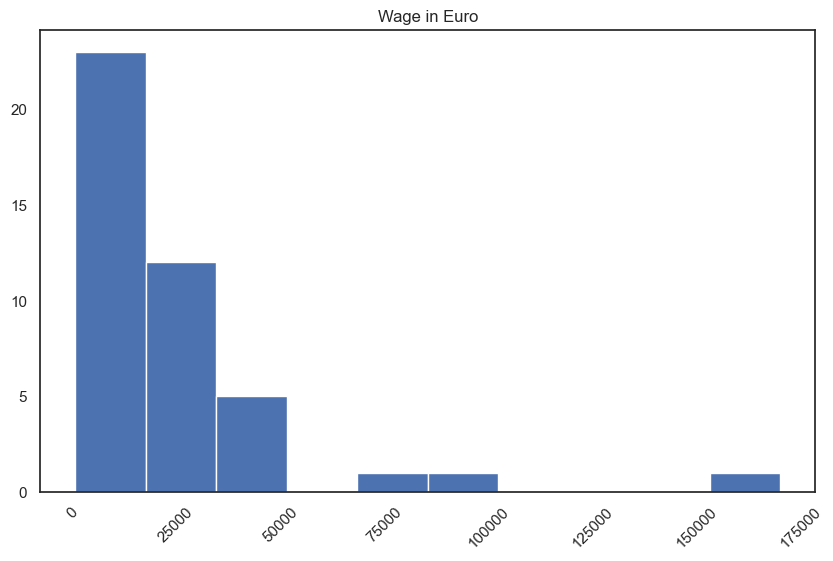

In [907]:
plt.figure(figsize=(10, 6))
plt.hist(x=df.wage_eur,bins=10)

plt.title("Wage in Euro")
plt.xticks(rotation=45)
plt.show()

We can see that very few players get more than 50,000 €

### Relationship between Overall Rating and Wages

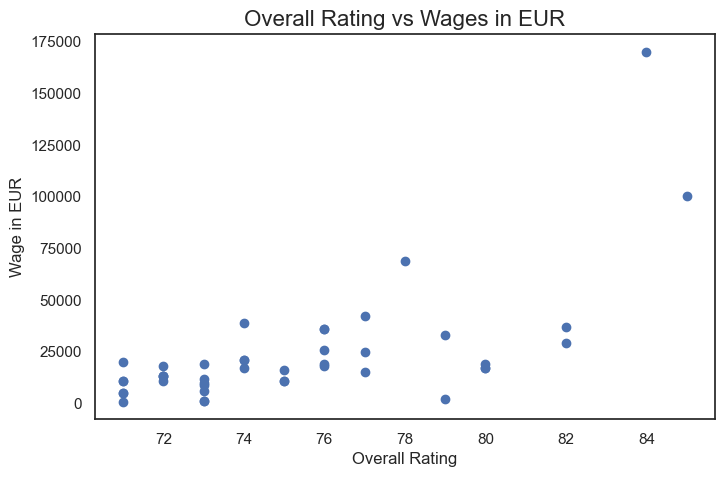

In [908]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(data = df, x= 'overall', y='wage_eur')
plt.xlabel("Overall Rating") 
plt.ylabel("Wage in EUR")
plt.title("Overall Rating vs Wages in EUR", fontsize = 16)
plt.show()

We can see that skilled players make more than the average players.

### Relationship between Player Postion and wages

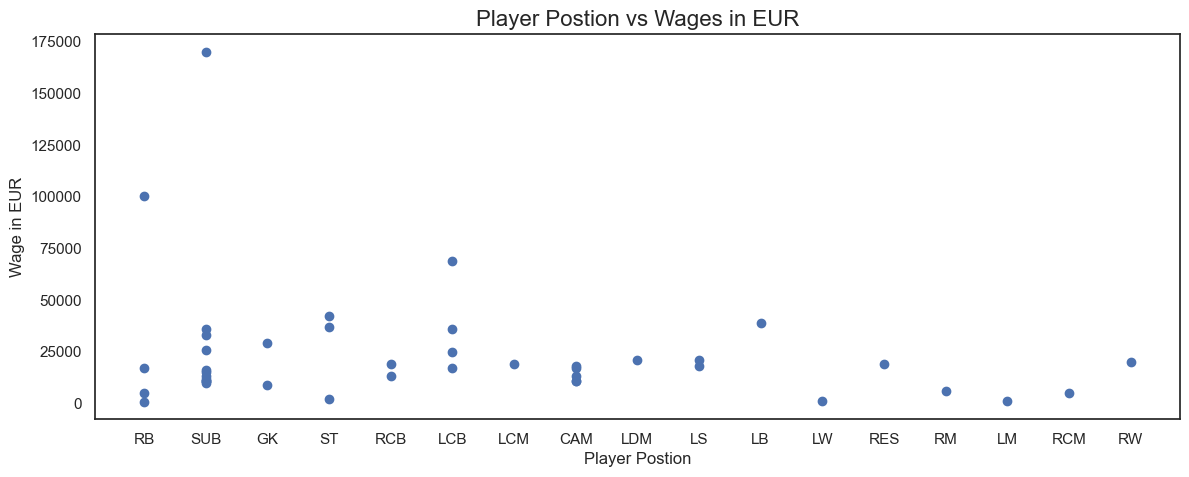

In [909]:
fig, ax = plt.subplots(figsize=(14,5))
plt.scatter(data = df, x= 'club_position', y='wage_eur')
plt.xlabel("Player Postion") 
plt.ylabel("Wage in EUR")
plt.title("Player Postion vs Wages in EUR", fontsize = 16)
plt.show()

There's no direct relationship between a player's position and his wage.

### Relationship between age and wages

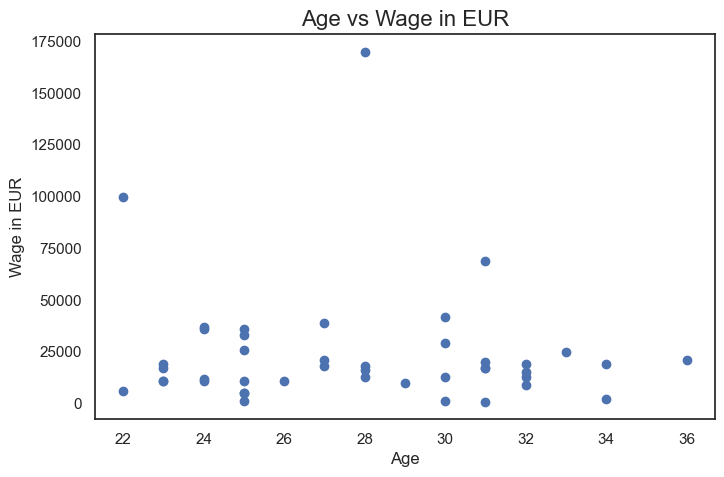

In [910]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(data = df, x= 'age', y='wage_eur')
plt.xlabel("Age") 
plt.ylabel("Wage in EUR")
plt.title("Age vs Wage in EUR", fontsize = 16)
plt.show()

Let's explore the age distrubution of our players.

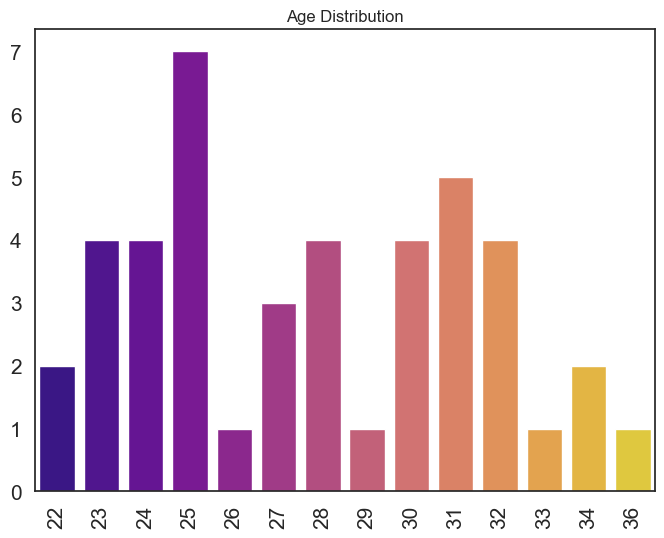

In [911]:
plt.figure(figsize=(8, 6))
sns.barplot(x=df.age.value_counts().index, y=df.age.value_counts().values,palette="plasma",capsize=.2)

plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.title('Age Distribution')
plt.show()

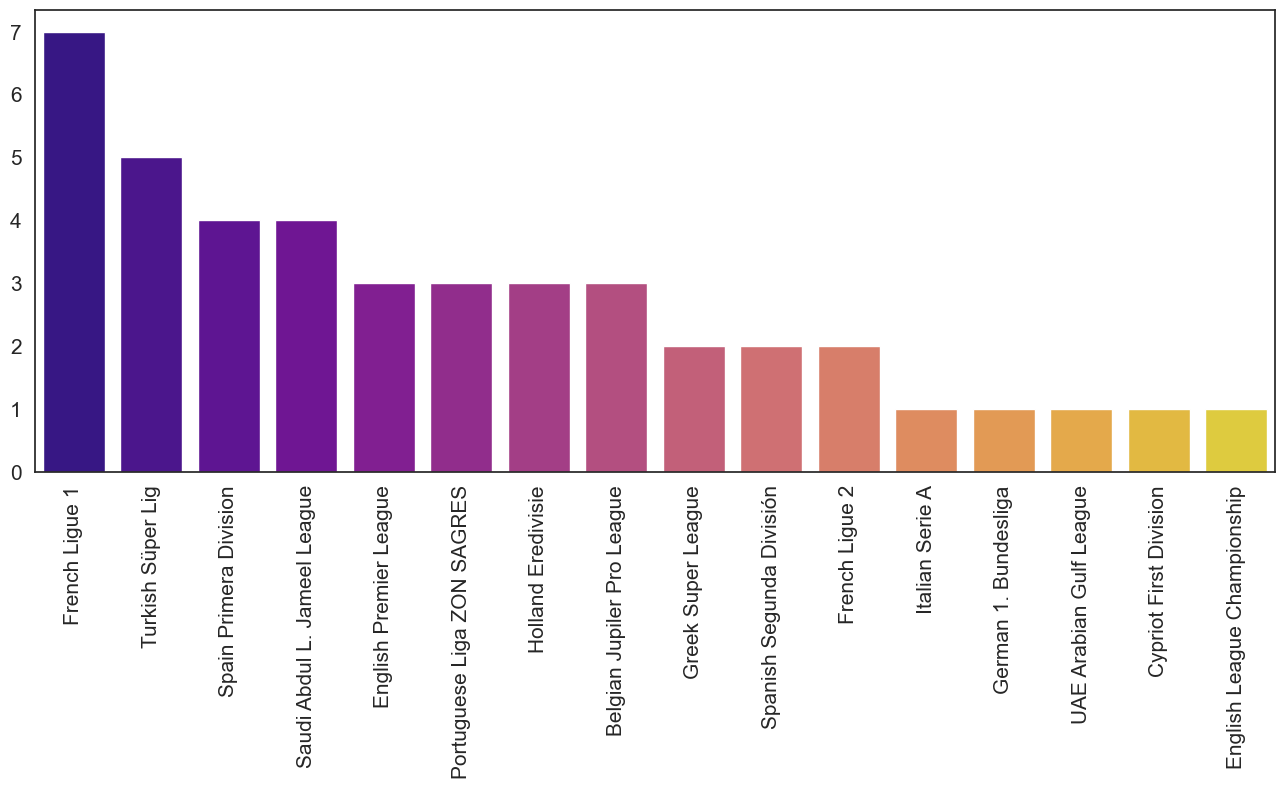

In [912]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.league_name.value_counts().index, y=df.league_name.value_counts().values,palette="plasma",capsize=.2)

plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.show()

We can see that the French Ligue 1 has the most Moroccan players amongts other leagues, followed by the Turkish and Spanish league.

Now let's compare the skills of two of the most controversial players in our National Team Morocco, Youssef En-Nesyri and Hamdallah. 

In [913]:
labels=np.array([
    "shooting",
    'passing',
    'dribbling',
    'defending',
    "overall",
    "potential",
])

In [914]:
striker1 = 'Y. En-Nesyri'
striker2 = 'A. Hamdallah'

In [915]:
i = df[df.short_name.str.contains(striker1)][labels].index.item()
stats = df.loc[i, labels].values

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=stats,
      theta=labels,
      fill='toself',
      name=striker1
))

i = df[df.short_name.str.contains(striker2)][labels].index.item()
stats = df.loc[i, labels].values

fig.add_trace(go.Scatterpolar(
      r=stats,
      theta=labels,
      fill='toself',
      name=striker2
))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,)

fig.show()

We can see clearly that En-Nseyri have more skill than Hamdallah overall, but Hamdallah is better in passing. I will let you be the judge of who should be in our Starting XI. 😉

In [916]:
print("Top 30 players\n")
x = ['overall','potential','wage_eur','pace','physic']
for i in x:
    print("Mean {} :  {:.0f}".format(i,top_players[i].mean()))

Top 30 players

Mean overall :  77
Mean potential :  79
Mean wage_eur :  30067
Mean pace :  70
Mean physic :  70


### V. Data Mining ⛏️

#### 1. Data pre-processing

First we gonna drop the name and save it for later use. 

In [917]:
names = df.short_name.tolist() 

df = df.drop(['short_name'], axis = 1) 

In [918]:
df.head()

,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
95,"RB, RWB",85,88,69500000.0,100000.0,22,1998-11-04,181,73,73.0,...,79+2,79+2,79+2,83+2,82+2,77+2,77+2,77+2,82+2,17+2
123,"RW, CAM",84,84,42500000.0,170000.0,28,1993-03-19,181,65,5.0,...,70+3,70+3,70+3,70+3,66+3,57+3,57+3,57+3,66+3,18+3
238,GK,82,82,20500000.0,29000.0,30,1991-04-05,192,78,481.0,...,32+2,32+2,32+2,28+2,27+2,28+2,28+2,28+2,27+2,81+1
276,"ST, LW",82,86,44000000.0,37000.0,24,1997-06-01,188,78,481.0,...,54+2,54+2,54+2,55+2,53+2,52+2,52+2,52+2,53+2,19+2
399,CB,80,80,7000000.0,19000.0,34,1987-04-17,189,94,111117.0,...,73+3,73+3,73+3,69+3,71+3,79+1,79+1,79+1,71+3,15+3


Now we're gonna remove all non numeric colums.

In [919]:
numeric_columns = df.select_dtypes(include=['number']).columns
df_processed = df[numeric_columns]

df_processed.head()

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_jersey_number,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
95,85,88,69500000.0,100000.0,22,181,73,73.0,1.0,2.0,...,46,80,75,78,76,10,8,14,6,8
123,84,84,42500000.0,170000.0,28,181,65,5.0,1.0,22.0,...,67,79,44,56,40,11,7,11,8,14
238,82,82,20500000.0,29000.0,30,192,78,481.0,1.0,13.0,...,24,57,20,18,15,82,79,76,81,84
276,82,86,44000000.0,37000.0,24,188,78,481.0,1.0,15.0,...,67,74,27,31,27,13,9,14,9,13
399,80,80,7000000.0,19000.0,34,189,94,111117.0,1.0,5.0,...,41,82,84,81,79,7,4,8,7,11


### 2. Model Building

#### 2.1. Manuel implementation of K-Means Algorithm

**K-means is an unsupervised machine learning technique that allow us to cluster data points. This enables us to find patterns in the data that can help us analyze it more effectively.** K-means is an iterative algorithm, which means that it will converge to the optimal clustering over time.


In [920]:
features = ["overall", "potential", "wage_eur", "value_eur", "age"]

df_man = df[features]

df_man.head()

,overall,potential,wage_eur,value_eur,age
95,85,88,100000.0,69500000.0,22
123,84,84,170000.0,42500000.0,28
238,82,82,29000.0,20500000.0,30
276,82,86,37000.0,44000000.0,24
399,80,80,19000.0,7000000.0,34


#### Pseudocode

1. Scale data to standardize values
2. Initialize random centroids
3. Get labels for each data point
4. Create new centroids
5. Plot the centroids
6. Repeat 3-5 until the centroids stop changing

In [921]:
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [922]:
centroids = random_centroids(df_man, 5)
centroids

,0,1,2,3,4
overall,76.0,76.0,73.0,77.0,73.0
potential,80.0,74.0,73.0,76.0,86.0
wage_eur,42000.0,800.0,100000.0,12000.0,18000.0
value_eur,1900000.0,1500000.0,14500000.0,5500000.0,4800000.0
age,30.0,22.0,27.0,32.0,25.0


In [923]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [924]:
labels = get_labels(df_man, centroids)

In [925]:
labels.value_counts()

3    12
0    11
2     8
4     8
1     4
dtype: int64

In [926]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [927]:
from IPython.display import clear_output

def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

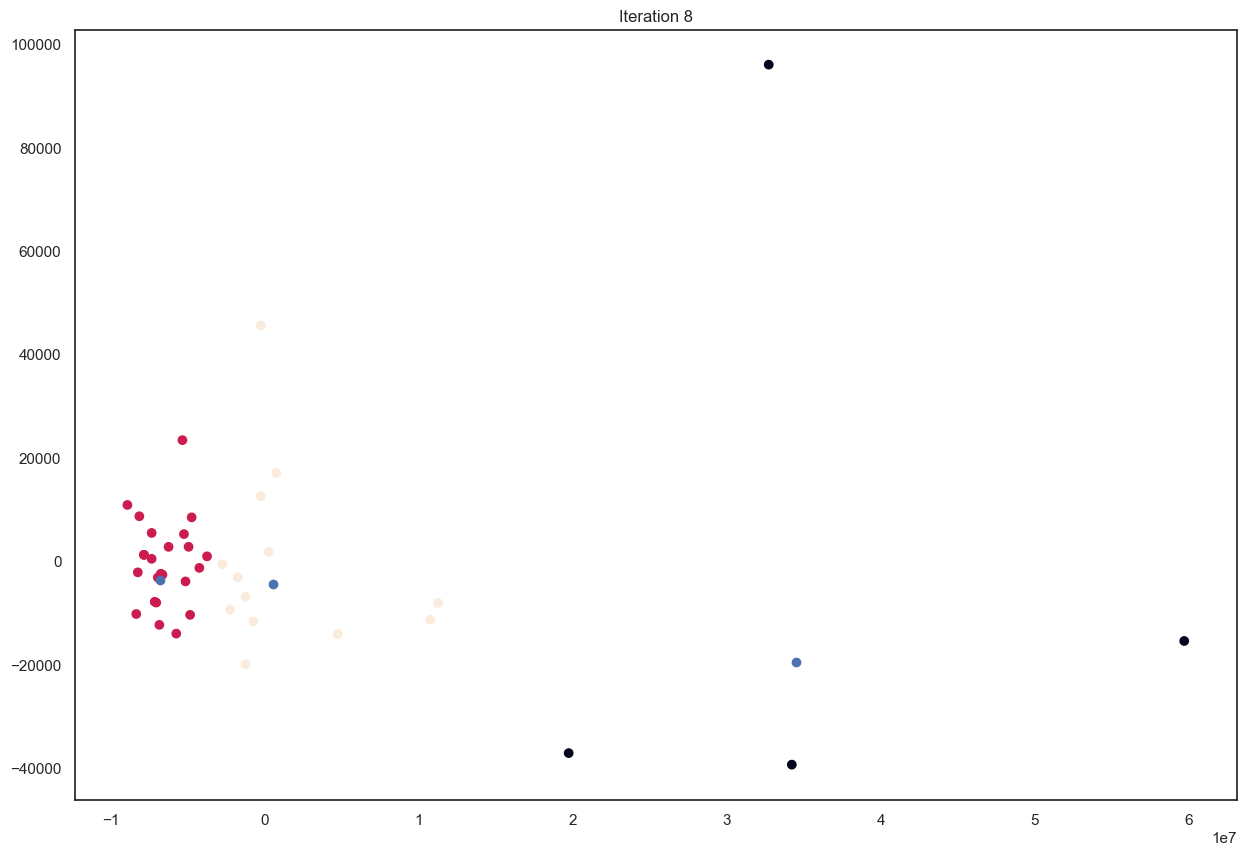

In [928]:
max_iterations = 50
centroid_count = 3

centroids = random_centroids(df_man, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    
    labels = get_labels(df_man, centroids)
    centroids = new_centroids(df_man, labels, centroid_count)
    plot_clusters(df_man, labels, centroids, iteration)
    iteration += 1

In [929]:
centroids

,0,1,2
overall,8.272762e+01,7.282334e+01,7.754433e+01
potential,8.573731e+01,7.468393e+01,7.912666e+01
wage_eur,5.718405e+04,9.781769e+03,2.026673e+04
value_eur,4.424988e+07,2.925955e+06,1.031069e+07
age,2.414793e+01,2.775817e+01,2.821005e+01


We can see with our manual implementation that we got 3 clusters.

#### 3.2. Implementation using KMeans of Scikit-learn

#### Normalizing the data

In [930]:
x = df_processed.values 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

#### Using PCA to reduce the columns into 2

For better visualization after, we are gonna stick with 2 columns.

In [931]:
pca = PCA(n_components = 2) # 2D PCA for the plot
reduced = pd.DataFrame(pca.fit_transform(X_norm))

We're gonna use the KMeans algorithm from the scikit-learn with 5 as clusters. 5 refer to the different player positions (goalkeeper, defender, defensive midfielder, offensive midfielder and striker)

In [932]:
kmeans = KMeans(n_clusters=5)

# Fit the input data to the model
kmeans = kmeans.fit(reduced)

# Get the cluster labels
labels = kmeans.predict(reduced)

# Centroid values
centroid = kmeans.cluster_centers_

# Cluster values
clusters = kmeans.labels_.tolist()

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [933]:
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head(10)

,x,y,cluster,name
0,-0.416940,-1.402227,0,A. Hakimi
1,-1.347289,-0.674665,2,H. Ziyech
2,1.833563,2.825214,3,Y. Bounou
3,-0.530509,-0.050283,2,Y. En-Nesyri
4,1.767683,-0.727340,1,M. Benatia
5,1.614146,-0.695639,1,Z. Feddal
6,0.089846,-0.904948,0,N. Mazraoui
7,-0.792849,0.075327,2,Y. El Arabi
8,-1.233885,0.076687,4,Munir
9,0.961730,-0.845448,1,R. Saïss


In [934]:
reduced['cluster'].unique()

array([0, 2, 3, 1, 4], dtype=int64)

We have now grouped our player into five clusters. If you are familiar with these players and their positions, you can see that they're correctly grouped.

For example:

- Noussair Mazraoui and Achraf Hakimi are two Right Back (RB) are in the same cluster. 
- Fedal and Benatia are both Central Back (CB) they are in the same cluster. 
- H. Ziyech and Y. En-Nesyri both Strikers (ST) are in the same cluster.

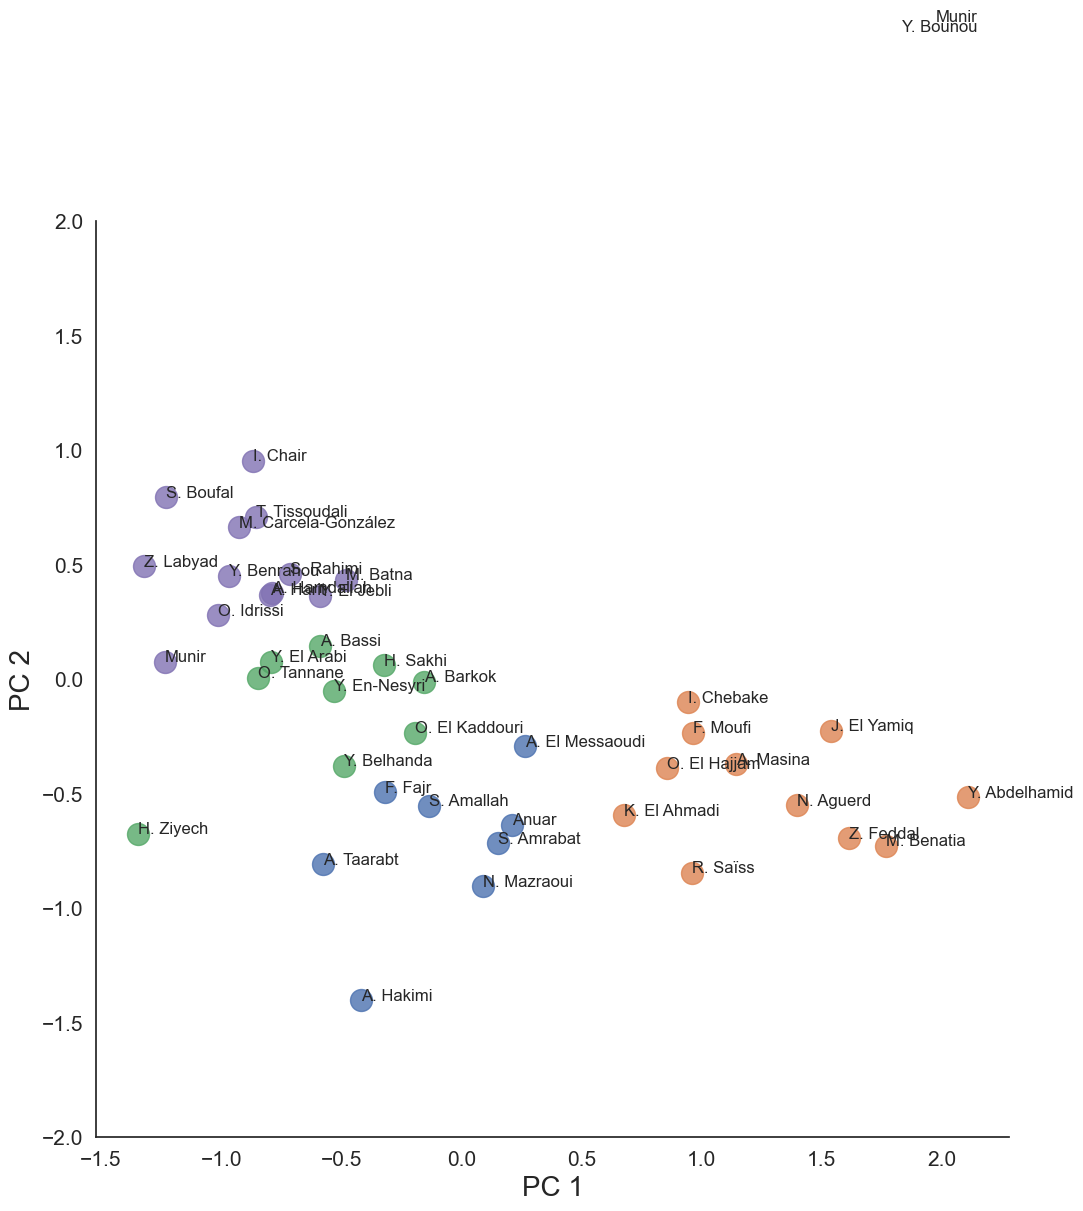

In [935]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, height = 10, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

In this plot, we can see:

🥅 In the top right, Y. Bounou and Munir Mhammedi the two goalkeepers of the national team. 

🟧 In orange we have our strikers like H. Ziyech, Y. En-Nesyri and S. Boufal.

🟩 In green offensive midfielders like A. Taarabt and S. Amallah and also offensive left and right backs like A. Hakimi and N. Mazraoui.

🟪 In purple we have the defensive midfielders like K. El Ahmadi.

🟦 And in the blue we have the central backs like M. Benatia and N. Aguerd

In [936]:
df['name'] = names
df.head()

,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,name
95,"RB, RWB",85,88,69500000.0,100000.0,22,1998-11-04,181,73,73.0,...,79+2,79+2,83+2,82+2,77+2,77+2,77+2,82+2,17+2,A. Hakimi
123,"RW, CAM",84,84,42500000.0,170000.0,28,1993-03-19,181,65,5.0,...,70+3,70+3,70+3,66+3,57+3,57+3,57+3,66+3,18+3,H. Ziyech
238,GK,82,82,20500000.0,29000.0,30,1991-04-05,192,78,481.0,...,32+2,32+2,28+2,27+2,28+2,28+2,28+2,27+2,81+1,Y. Bounou
276,"ST, LW",82,86,44000000.0,37000.0,24,1997-06-01,188,78,481.0,...,54+2,54+2,55+2,53+2,52+2,52+2,52+2,53+2,19+2,Y. En-Nesyri
399,CB,80,80,7000000.0,19000.0,34,1987-04-17,189,94,111117.0,...,73+3,73+3,69+3,71+3,79+1,79+1,79+1,71+3,15+3,M. Benatia


In [937]:
df_decision = pd.merge(df, reduced, on="name")
df_decision = df_decision[['name', 'player_positions', 'cluster']]

df_decision.head(8)

,name,player_positions,cluster
0,A. Hakimi,"RB, RWB",0
1,H. Ziyech,"RW, CAM",2
2,Y. Bounou,GK,3
3,Y. En-Nesyri,"ST, LW",2
4,M. Benatia,CB,1
5,Z. Feddal,CB,1
6,N. Mazraoui,RB,0
7,Y. El Arabi,ST,2


We can see that players with similar player position have the same cluster number.